In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import rcParams

ruta= "/content/FRR_KDF17.xlsx"
df= pd.read_excel(ruta)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   corrida_id            4 non-null      int64 
 1   timestamp             4 non-null      object
 2   condicion             4 non-null      object
 3   capsula_361_sublote   4 non-null      object
 4   capsula_730_sublote   4 non-null      object
 5   frr_faltante_361      4 non-null      int64 
 6   frr_insuficiente_361  4 non-null      int64 
 7   frr_excesivo_361      4 non-null      int64 
 8   frr_posicion_361      4 non-null      int64 
 9   frr_faltante_730      4 non-null      int64 
 10  frr_insuficiente_730  4 non-null      int64 
 11  frr_excesivo_730      4 non-null      int64 
 12  frr_posicion_730      4 non-null      int64 
 13  desperdicio_total     4 non-null      int64 
 14  duracion_minutos      4 non-null      int64 
dtypes: int64(11), object(4)
memory usage: 612.0+

In [10]:
# Configurar estilo
rcParams['figure.figsize'] = (14, 8)
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 11

# Convertir timestamp a datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%Y %I:%M:%S %p', errors='coerce')

# Crear orden cronológico
df = df.sort_values('timestamp').reset_index(drop=True)

print("="*70)
print("ANÁLISIS DE DESPERDICIO - CÁPSULAS CON Y SIN CONDICIÓN")
print("="*70)
print(f"\nTotal de corridas analizadas: {len(df)}")
print(f"Corridas con condición: {len(df[df['condicion'] == 'Con condicion'])}")
print(f"Corridas sin condición: {len(df[df['condicion'] == 'Sin condicion'])}")

ANÁLISIS DE DESPERDICIO - CÁPSULAS CON Y SIN CONDICIÓN

Total de corridas analizadas: 4
Corridas con condición: 2
Corridas sin condición: 2


#### ============ ANÁLISIS AGREGADO ============

In [13]:
print("\n" + "="*70)
print("ESTADÍSTICAS AGREGADAS")
print("="*70)

stats_condicion = df.groupby('condicion').agg({
    'desperdicio_total': ['mean', 'std', 'min', 'max', 'sum'],
    'frr_faltante_361': 'mean',
    'frr_insuficiente_361': 'mean',
    'frr_excesivo_361': 'mean',
    'frr_posicion_361': 'mean',
    'frr_faltante_730': 'mean',
    'frr_insuficiente_730': 'mean',
    'frr_excesivo_730': 'mean',
    'frr_posicion_730': 'mean'
})

print("\nDesperdicio Total por Condición:")
print(stats_condicion['desperdicio_total'])

# Calcular diferencia porcentual
desperdicio_con = df[df['condicion'] == 'Con condicion']['desperdicio_total'].mean()
desperdicio_sin = df[df['condicion'] == 'Sin condicion']['desperdicio_total'].mean()
diferencia_pct = ((desperdicio_sin - desperdicio_con) / desperdicio_sin) * 100

print(f"\nDesperdicio promedio CON condición: {desperdicio_con:.2f} cápsulas")
print(f"Desperdicio promedio SIN condición: {desperdicio_sin:.2f} cápsulas")
print(f"\n✓ REDUCCIÓN DE DESPERDICIO: {diferencia_pct:.1f}%")


ESTADÍSTICAS AGREGADAS

Desperdicio Total por Condición:
                 mean          std   min   max   sum
condicion                                           
Con condicion   617.5   386.787409   344   891  1235
Sin condicion  2173.5  1427.648591  1164  3183  4347

Desperdicio promedio CON condición: 617.50 cápsulas
Desperdicio promedio SIN condición: 2173.50 cápsulas

✓ REDUCCIÓN DE DESPERDICIO: 71.6%


###  ============ FIGURA 1: COMPARATIVA GENERAL ============

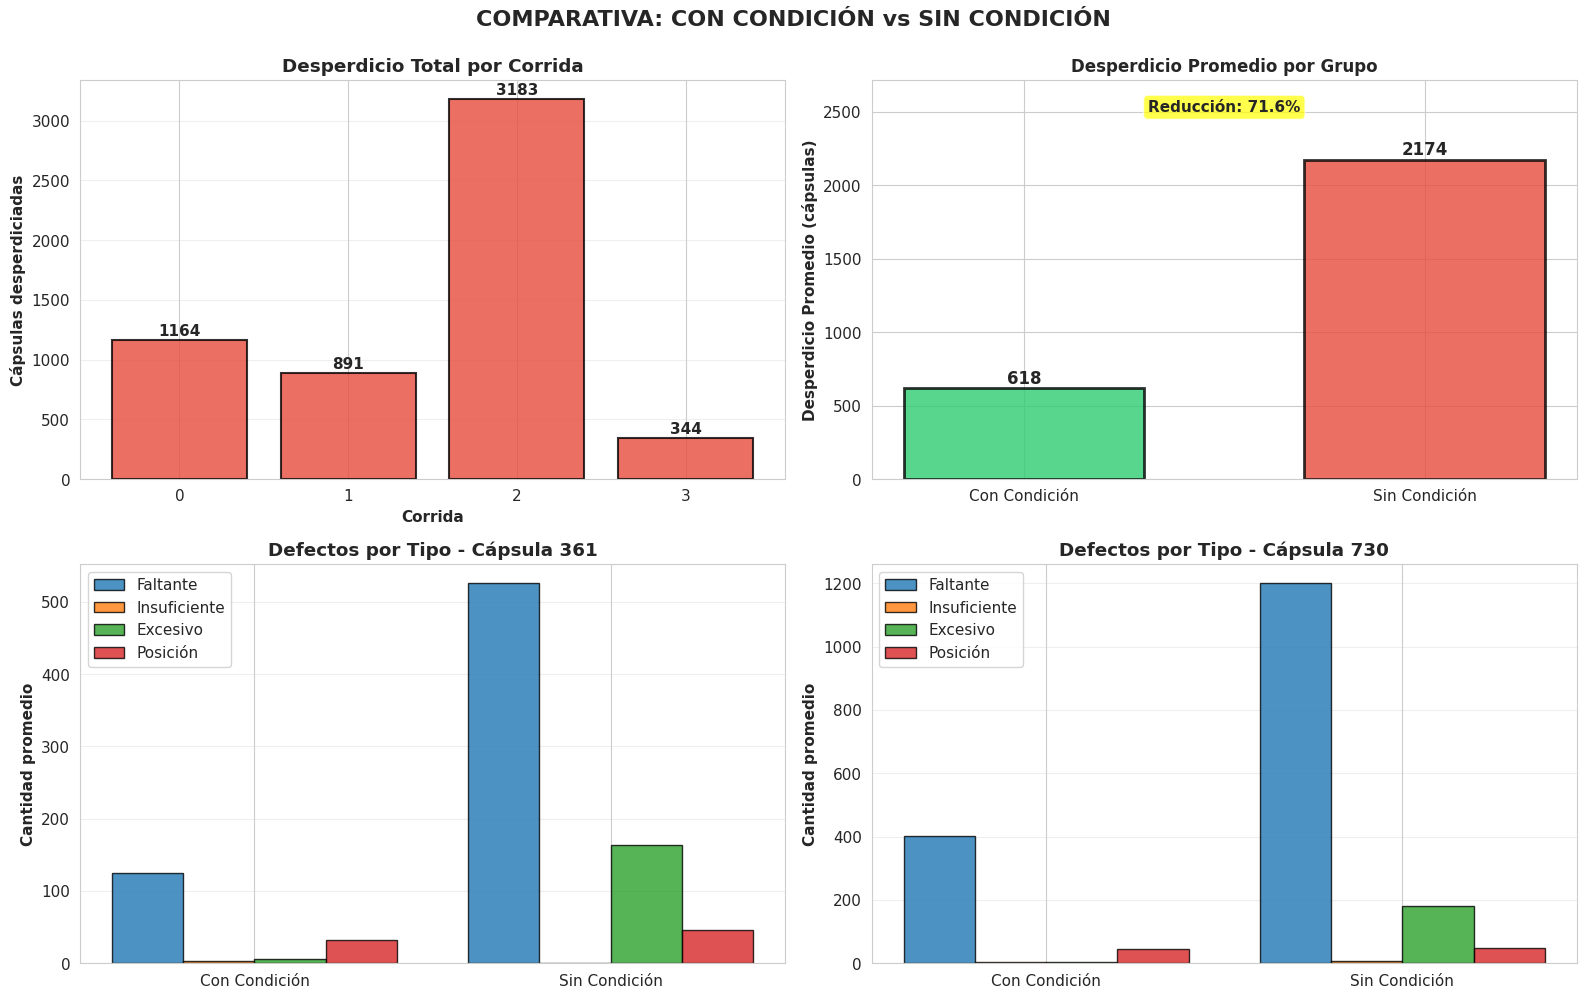

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('COMPARATIVA: CON CONDICIÓN vs SIN CONDICIÓN', fontsize=16, fontweight='bold', y=0.995)

# Gráfica 1.1: Desperdicio total por corrida
ax = axes[0, 0]
colors = ['#2ecc71' if x == 'con_condicion' else '#e74c3c' for x in df['condicion']]
bars = ax.bar(df.index, df['desperdicio_total'], color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Corrida', fontweight='bold')
ax.set_ylabel('Cápsulas desperdiciadas', fontweight='bold')
ax.set_title('Desperdicio Total por Corrida', fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.set_xticks(df.index)
# Agregar valores en las barras
for i, (bar, val) in enumerate(zip(bars, df['desperdicio_total'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
            f'{int(val)}', ha='center', va='bottom', fontweight='bold')

# Gráfica 1.2: Promedio de desperdicio por condición
ax = axes[0, 1]
promedios = df.groupby('condicion')['desperdicio_total'].mean()
colores_prom = ['#2ecc71', '#e74c3c']
bars = ax.bar(['Con Condición', 'Sin Condición'], promedios.values,
              color=colores_prom, alpha=0.8, edgecolor='black', linewidth=2, width=0.6)
ax.set_ylabel('Desperdicio Promedio (cápsulas)', fontweight='bold')
ax.set_title('Desperdicio Promedio por Grupo', fontweight='bold', fontsize=12)
ax.set_ylim(0, promedios.max() * 1.25)
for bar, val in zip(bars, promedios.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            f'{val:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=12)
# Agregar % de reducción
ax.text(0.5, promedios.max() * 1.15, f'Reducción: {diferencia_pct:.1f}%',
        ha='center', fontsize=11, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# Gráfica 1.3: Distribución de tipos de FRR - Cápsula 361
ax = axes[1, 0]
frr_tipos_361 = {
    'Faltante': df.groupby('condicion')[['frr_faltante_361']].mean().values.flatten(),
    'Insuficiente': df.groupby('condicion')[['frr_insuficiente_361']].mean().values.flatten(),
    'Excesivo': df.groupby('condicion')[['frr_excesivo_361']].mean().values.flatten(),
    'Posición': df.groupby('condicion')[['frr_posicion_361']].mean().values.flatten()
}
x = np.arange(2)
width = 0.2
for i, (tipo, vals) in enumerate(frr_tipos_361.items()):
    ax.bar(x + i*width, vals, width, label=tipo, alpha=0.8, edgecolor='black')
ax.set_ylabel('Cantidad promedio', fontweight='bold')
ax.set_title('Defectos por Tipo - Cápsula 361', fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(['Con Condición', 'Sin Condición'])
ax.legend(loc='upper left')
ax.grid(axis='y', alpha=0.3)

# Gráfica 1.4: Distribución de tipos de FRR - Cápsula 730
ax = axes[1, 1]
frr_tipos_730 = {
    'Faltante': df.groupby('condicion')[['frr_faltante_730']].mean().values.flatten(),
    'Insuficiente': df.groupby('condicion')[['frr_insuficiente_730']].mean().values.flatten(),
    'Excesivo': df.groupby('condicion')[['frr_excesivo_730']].mean().values.flatten(),
    'Posición': df.groupby('condicion')[['frr_posicion_730']].mean().values.flatten()
}
x = np.arange(2)
for i, (tipo, vals) in enumerate(frr_tipos_730.items()):
    ax.bar(x + i*width, vals, width, label=tipo, alpha=0.8, edgecolor='black')
ax.set_ylabel('Cantidad promedio', fontweight='bold')
ax.set_title('Defectos por Tipo - Cápsula 730', fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(['Con Condición', 'Sin Condición'])
ax.legend(loc='upper left')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('01_comparativa_general.png', dpi=300, bbox_inches='tight')
plt.show()

###  ============ FIGURA 2: TENDENCIA TEMPORAL ============

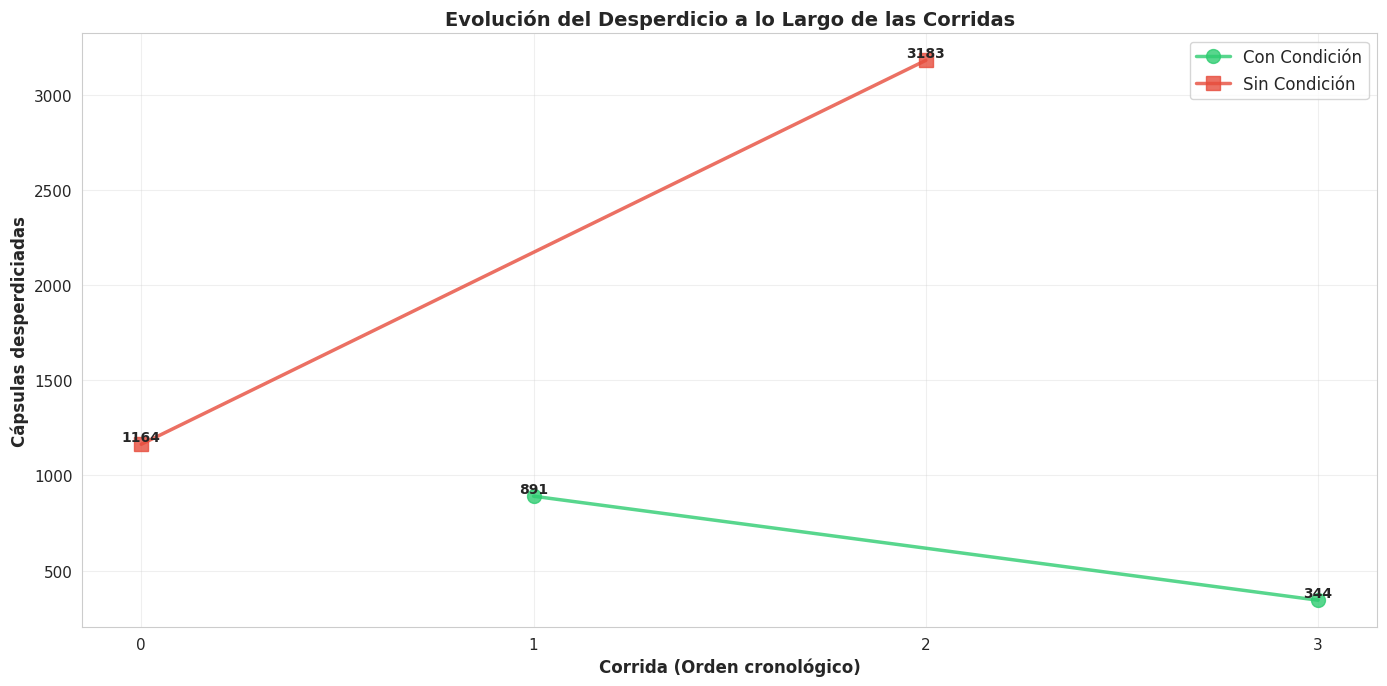

In [16]:
fig, ax = plt.subplots(figsize=(14, 7))

# Separar datos por condición
con_cond = df[df['condicion'] == 'Con condicion']
sin_cond = df[df['condicion'] == 'Sin condicion']

ax.plot(con_cond.index, con_cond['desperdicio_total'],
        marker='o', linewidth=2.5, markersize=10, label='Con Condición',
        color='#2ecc71', alpha=0.8)
ax.plot(sin_cond.index, sin_cond['desperdicio_total'],
        marker='s', linewidth=2.5, markersize=10, label='Sin Condición',
        color='#e74c3c', alpha=0.8)

# Agregar valores en los puntos
for idx, row in df.iterrows():
    ax.text(idx, row['desperdicio_total'] + 15, f"{int(row['desperdicio_total'])}",
            ha='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Corrida (Orden cronológico)', fontweight='bold', fontsize=12)
ax.set_ylabel('Cápsulas desperdiciadas', fontweight='bold', fontsize=12)
ax.set_title('Evolución del Desperdicio a lo Largo de las Corridas',
             fontweight='bold', fontsize=14)
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xticks(df.index)

plt.tight_layout()
plt.savefig('02_tendencia_temporal.png', dpi=300, bbox_inches='tight')
plt.show()


### ============ FIGURA 3: DESGLOSE DETALLADO POR TIPO DE CÁPSULA ============

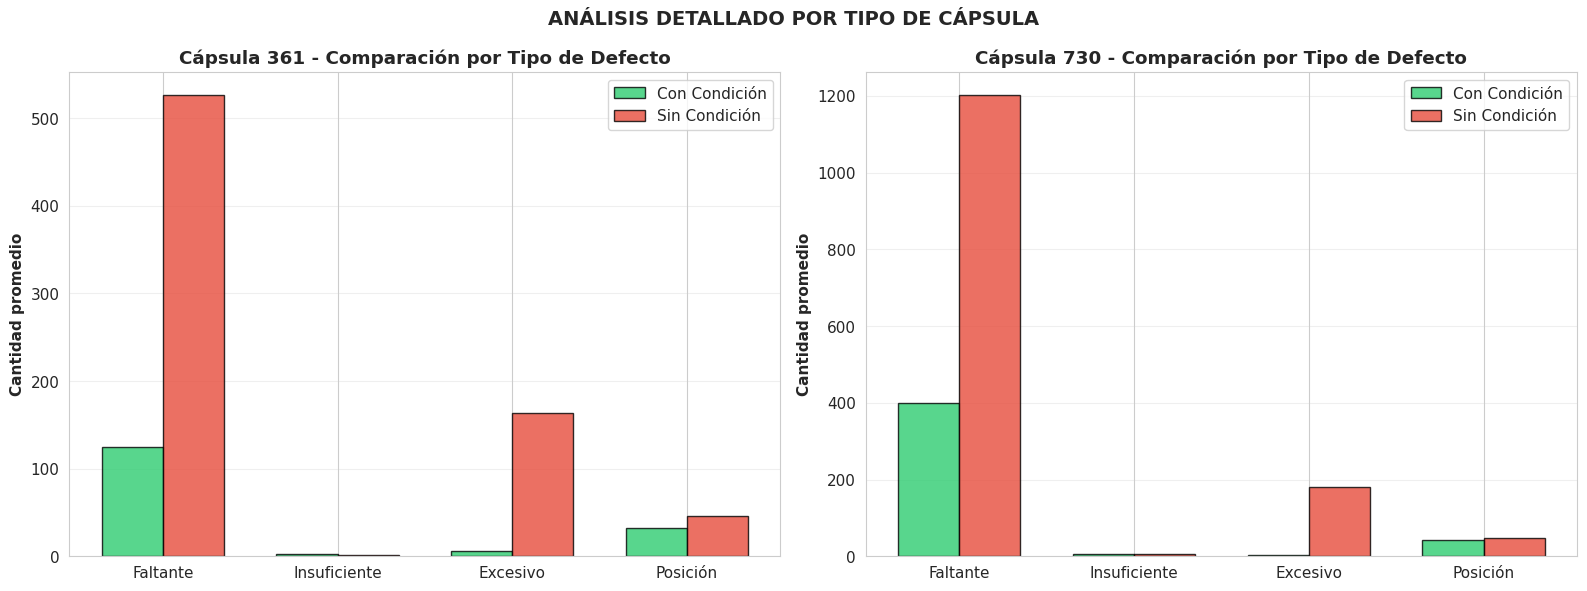

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('ANÁLISIS DETALLADO POR TIPO DE CÁPSULA', fontsize=14, fontweight='bold')

# Cápsula 361
ax = axes[0]
frr_361_con = df[df['condicion'] == 'Con condicion'][[
    'frr_faltante_361', 'frr_insuficiente_361', 'frr_excesivo_361', 'frr_posicion_361']].mean()
frr_361_sin = df[df['condicion'] == 'Sin condicion'][[
    'frr_faltante_361', 'frr_insuficiente_361', 'frr_excesivo_361', 'frr_posicion_361']].mean()

x = np.arange(len(frr_361_con))
width = 0.35
ax.bar(x - width/2, frr_361_con.values, width, label='Con Condición',
       color='#2ecc71', alpha=0.8, edgecolor='black')
ax.bar(x + width/2, frr_361_sin.values, width, label='Sin Condición',
       color='#e74c3c', alpha=0.8, edgecolor='black')

ax.set_ylabel('Cantidad promedio', fontweight='bold')
ax.set_title('Cápsula 361 - Comparación por Tipo de Defecto', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['Faltante', 'Insuficiente', 'Excesivo', 'Posición'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Cápsula 730
ax = axes[1]
frr_730_con = df[df['condicion'] == 'Con condicion'][[
    'frr_faltante_730', 'frr_insuficiente_730', 'frr_excesivo_730', 'frr_posicion_730']].mean()
frr_730_sin = df[df['condicion'] == 'Sin condicion'][[
    'frr_faltante_730', 'frr_insuficiente_730', 'frr_excesivo_730', 'frr_posicion_730']].mean()

x = np.arange(len(frr_730_con))
ax.bar(x - width/2, frr_730_con.values, width, label='Con Condición',
       color='#2ecc71', alpha=0.8, edgecolor='black')
ax.bar(x + width/2, frr_730_sin.values, width, label='Sin Condición',
       color='#e74c3c', alpha=0.8, edgecolor='black')

ax.set_ylabel('Cantidad promedio', fontweight='bold')
ax.set_title('Cápsula 730 - Comparación por Tipo de Defecto', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['Faltante', 'Insuficiente', 'Excesivo', 'Posición'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('03_desglose_capsulas.png', dpi=300, bbox_inches='tight')
plt.show()

### ============ FIGURA 4: RESUMEN EJECUTIVO ============

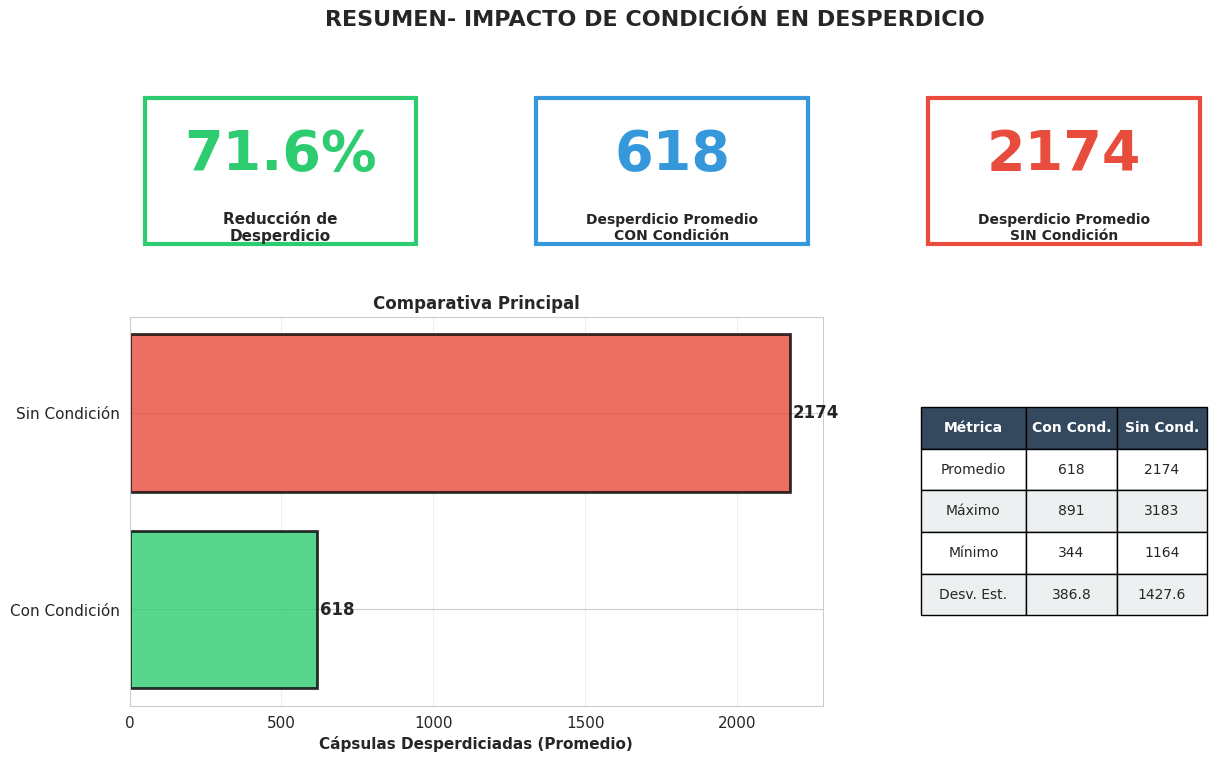


✓ Análisis completado. Se generaron 4 gráficas en alta resolución (300 DPI)


In [20]:
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.3)

fig.suptitle('RESUMEN- IMPACTO DE CONDICIÓN EN DESPERDICIO',
             fontsize=16, fontweight='bold', y=0.98)

# KPI 1: Reducción porcentual
ax1 = fig.add_subplot(gs[0, 0])
ax1.text(0.5, 0.6, f'{diferencia_pct:.1f}%', ha='center', va='center',
         fontsize=40, fontweight='bold', color='#2ecc71')
ax1.text(0.5, 0.15, 'Reducción de\nDesperdicio', ha='center', va='center',
         fontsize=11, fontweight='bold')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.axis('off')
ax1.add_patch(plt.Rectangle((0.05, 0.05), 0.9, 0.9, fill=False,
                             edgecolor='#2ecc71', linewidth=3))

# KPI 2: Desperdicio con condición
ax2 = fig.add_subplot(gs[0, 1])
ax2.text(0.5, 0.6, f'{desperdicio_con:.0f}', ha='center', va='center',
         fontsize=40, fontweight='bold', color='#3498db')
ax2.text(0.5, 0.15, 'Desperdicio Promedio\nCON Condición', ha='center', va='center',
         fontsize=10, fontweight='bold')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.axis('off')
ax2.add_patch(plt.Rectangle((0.05, 0.05), 0.9, 0.9, fill=False,
                             edgecolor='#3498db', linewidth=3))

# KPI 3: Desperdicio sin condición
ax3 = fig.add_subplot(gs[0, 2])
ax3.text(0.5, 0.6, f'{desperdicio_sin:.0f}', ha='center', va='center',
         fontsize=40, fontweight='bold', color='#e74c3c')
ax3.text(0.5, 0.15, 'Desperdicio Promedio\nSIN Condición', ha='center', va='center',
         fontsize=10, fontweight='bold')
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)
ax3.axis('off')
ax3.add_patch(plt.Rectangle((0.05, 0.05), 0.9, 0.9, fill=False,
                             edgecolor='#e74c3c', linewidth=3))

# Gráfica grande de comparativa
ax4 = fig.add_subplot(gs[1:, 0:2])
condiciones = ['Con Condición', 'Sin Condición']
desper = [desperdicio_con, desperdicio_sin]
colores = ['#2ecc71', '#e74c3c']
bars = ax4.barh(condiciones, desper, color=colores, alpha=0.8, edgecolor='black', linewidth=2)
ax4.set_xlabel('Cápsulas Desperdiciadas (Promedio)', fontweight='bold', fontsize=11)
ax4.set_title('Comparativa Principal', fontweight='bold', fontsize=12)
for bar, val in zip(bars, desper):
    ax4.text(val + 10, bar.get_y() + bar.get_height()/2, f'{val:.0f}',
             va='center', fontweight='bold', fontsize=12)
ax4.grid(axis='x', alpha=0.3)

# Tabla de resumen
ax5 = fig.add_subplot(gs[1:, 2])
ax5.axis('tight')
ax5.axis('off')

tabla_data = [
    ['Métrica', 'Con Cond.', 'Sin Cond.'],
    ['Promedio', f'{desperdicio_con:.0f}', f'{desperdicio_sin:.0f}'],
    ['Máximo', f"{df[df['condicion'] == 'Con condicion']['desperdicio_total'].max()}",
     f"{df[df['condicion'] == 'Sin condicion']['desperdicio_total'].max()}"],
    ['Mínimo', f"{df[df['condicion'] == 'Con condicion']['desperdicio_total'].min()}",
     f"{df[df['condicion'] == 'Sin condicion']['desperdicio_total'].min()}"],
    ['Desv. Est.',
     f"{df[df['condicion'] == 'Con condicion']['desperdicio_total'].std():.1f}",
     f"{df[df['condicion'] == 'Sin condicion']['desperdicio_total'].std():.1f}"]
]

table = ax5.table(cellText=tabla_data, cellLoc='center', loc='center',
                  colWidths=[0.35, 0.3, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Colorear header
for i in range(3):
    table[(0, i)].set_facecolor('#34495e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Colorear filas alternas
for i in range(1, len(tabla_data)):
    for j in range(3):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#ecf0f1')

plt.savefig('04_resumen_ejecutivo.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("✓ Análisis completado. Se generaron 4 gráficas en alta resolución (300 DPI)")
print("="*70)

In [19]:
df

,corrida_id,timestamp,condicion,capsula_361_sublote,capsula_730_sublote,frr_faltante_361,frr_insuficiente_361,frr_excesivo_361,frr_posicion_361,frr_faltante_730,frr_insuficiente_730,frr_excesivo_730,frr_posicion_730,desperdicio_total,duracion_minutos
0,1,2025-12-12 11:55:00,Sin condicion,0001382865-4,00011365121-4,140,0,13,34,926,4,13,34,1164,30
1,2,2025-12-12 12:35:00,Con condicion,0001382865-2,00011365121-2,163,4,11,32,623,7,4,47,891,26
2,3,NaT,Sin condicion,0001382865-1,00011365121-3,912,2,315,59,1476,8,348,63,3183,40
3,4,NaT,Con condicion,0001382865-3,00011365121-1,86,1,2,33,178,3,1,40,344,23
